In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

In [2]:
df = pd.read_csv(r'C:\Users\HP\Downloads\vn100_prices.csv', parse_dates=['TradingDate'])
df.set_index('TradingDate', inplace=True)
df.head()

,AAA,ACB,AGG,ANV,ASM,BCG,BCM,BID,BMP,BVH,...,VIB,VIC,VIX,VJC,VND,VNM,VPB,VPI,VRE,VSH
TradingDate,,,,,,,,,,,,,,,,,,,,,
2021-07-15,14092,18383,35518,24477,8324,8745,43506,29988,42473,45594,...,24463,90668,8505,114800,14386,74177,21456,28536,28000,17741
2021-07-16,13915,18860,35448,24341,8600,8782,41439,29847,42699,46045,...,24436,94046,8428,115400,14281,74786,21624,28495,27700,17656
2021-07-19,13076,18046,35238,22706,8084,8224,39131,27846,41721,43337,...,22747,91468,7856,114000,13199,74002,20115,28131,26800,17107
2021-07-20,13650,19029,35308,23978,8324,8447,38554,28794,42473,45052,...,22883,91557,7837,114500,14456,74786,20316,27928,26700,17741
2021-07-21,13650,18973,35518,23251,8496,8373,37689,28583,42172,44691,...,22393,92446,7780,114000,14456,74264,20216,28049,27400,17234


## 1. Construct an equally weighted portfolio

In [49]:
sub_df = df.iloc[:, 10:15]
ret = sub_df.pct_change().dropna()
ret.head()

,BWE,CII,CMG,CRE,CTD
TradingDate,,,,,
2021-07-16,0.066483,0.015844,0.001402,0.035686,-0.004944
2021-07-19,-0.013559,-0.024993,-0.023854,-0.022971,-0.011623
2021-07-20,0.000000,0.015996,0.024437,0.048212,0.005027
2021-07-21,0.052199,0.009486,-0.004200,0.003405,-0.003349
2021-07-22,0.002613,0.018729,0.015519,0.069323,0.010082


In [64]:
ret.describe()

,BWE,CII,CMG,CRE,CTD
count,700.000000,700.000000,700.000000,700.000000,700.000000
mean,0.000797,0.000950,0.002176,-0.000425,0.001163
std,0.019338,0.037901,0.024960,0.026863,0.030661
min,-0.069513,-0.368079,-0.088339,-0.130973,-0.069958
25%,-0.008472,-0.015604,-0.008962,-0.013839,-0.014027
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.009313,0.020264,0.013330,0.011628,0.016925
max,0.076276,0.335229,0.069902,0.069928,0.069971


In [51]:
expected_ret = ret.mean()
std_ret = ret.std()
cov = ret.cov()

In [52]:
# create an array of expected return for 3 assets
expected_returns = np.array(expected_ret)

# create an array of standard deviation for 3 assets
std_devs = np.array(std_ret)

# convert covariance matrix to numpy array
cov_matrix = cov.values
if cov_matrix.shape == (1,1,3):
    cov_matrix = cov_matrix[0, 0]

In [54]:
# assign weights for 5 assets
weights = np.array([1/5, 1/5, 1/5, 1/5, 1/5])

portfolio_return = np.dot(weights, expected_returns) # calculate portfolio return
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights)) # calculate portfolio variance
portfolio_volatility = np.sqrt(portfolio_variance) # calculate portfolio standard deviation

print(f'Expected Portfolio Return: {portfolio_return}')
print(f'Portfolio Volatility: {portfolio_volatility}')

Expected Portfolio Return: 0.0009322170642705907
Portfolio Volatility: 0.01932173003205864


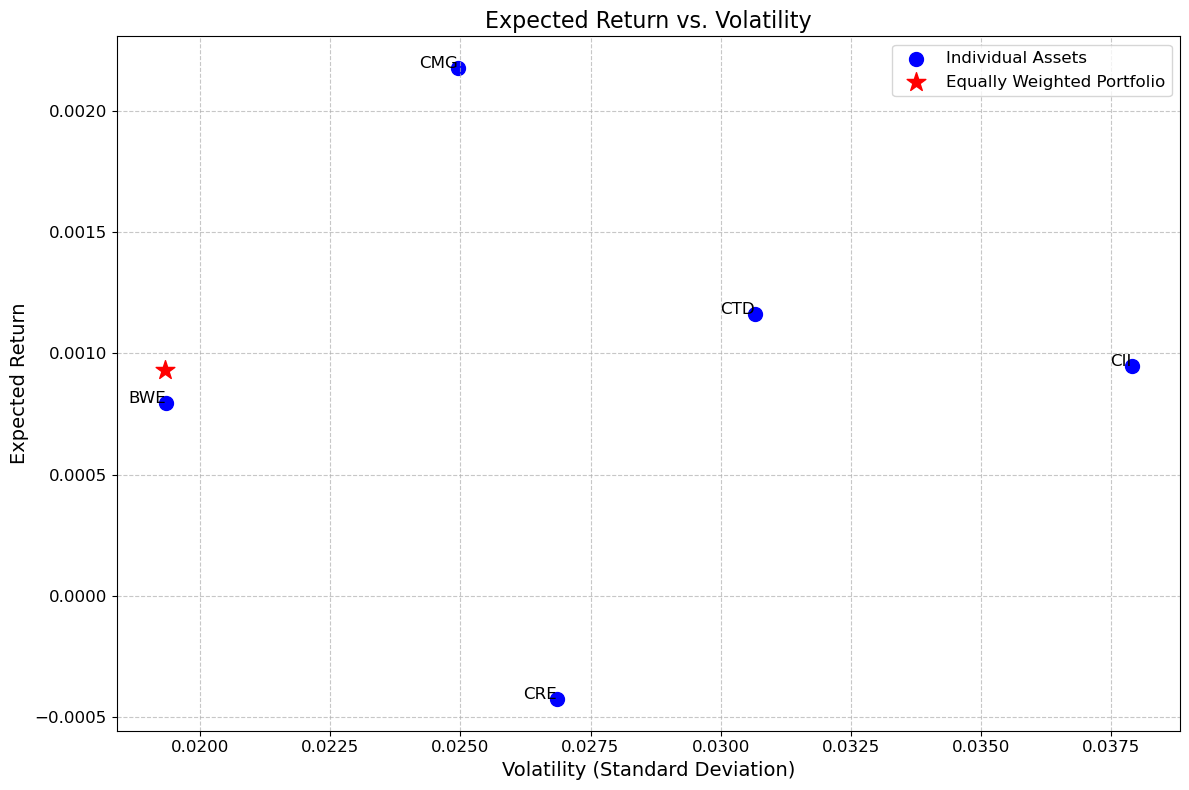

In [55]:
plt.figure(figsize=(12,8))
plt.scatter(std_devs, expected_returns, c = 'blue', s = 100, label = 'Individual Assets') # scatter plot for 3 individual assets
for i, txt in enumerate(['BWE', 'CII', 'CMG', 'CRE', 'CTD']):
    plt.annotate(txt, (std_devs[i], expected_returns[i]), fontsize=12, ha = 'right') 
plt.scatter(portfolio_volatility, portfolio_return, c='red', marker = '*', s = 200, label = 'Equally Weighted Portfolio') # scatter plot for equally portfolio
plt.xlabel('Volatility (Standard Deviation)', fontsize=14)
plt.ylabel('Expected Return', fontsize=14)
plt.title('Expected Return vs. Volatility', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## 2. Model selection (Bidirectional-GRU)

In [56]:
cols = df.iloc[:, 10:15].columns
data = df[cols].values

In [57]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [58]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [59]:
SEQ_LENGTH = 30  # Length of the input sequences
X, y = create_sequences(data_scaled, SEQ_LENGTH)

In [60]:
# Split into train and test sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [61]:
model = Sequential([
    Bidirectional(GRU(100, activation='relu'), input_shape=(SEQ_LENGTH, 5)),
    Dense(5)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 200)               64200     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 65205 (254.71 KB)
Trainable params: 65205 (254.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 3. Fit the model

In [62]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=125,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/125
14/14 [==============================] - 3s 46ms/step - loss: 0.1075 - val_loss: 0.0254
Epoch 2/125
14/14 [==============================] - 0s 21ms/step - loss: 0.0205 - val_loss: 0.0168
Epoch 3/125
14/14 [==============================] - 0s 21ms/step - loss: 0.0109 - val_loss: 0.0126
Epoch 4/125
14/14 [==============================] - 0s 19ms/step - loss: 0.0070 - val_loss: 0.0101
Epoch 5/125
14/14 [==============================] - 0s 18ms/step - loss: 0.0052 - val_loss: 0.0110
Epoch 6/125
14/14 [==============================] - 0s 19ms/step - loss: 0.0044 - val_loss: 0.0081
Epoch 7/125
14/14 [==============================] - 0s 19ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 8/125
14/14 [==============================] - 0s 19ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 9/125
14/14 [==============================] - 0s 19ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 10/125
14/14 [==============================] - 0s 20ms/step - loss: 0.0026 - val_loss: 0.0021

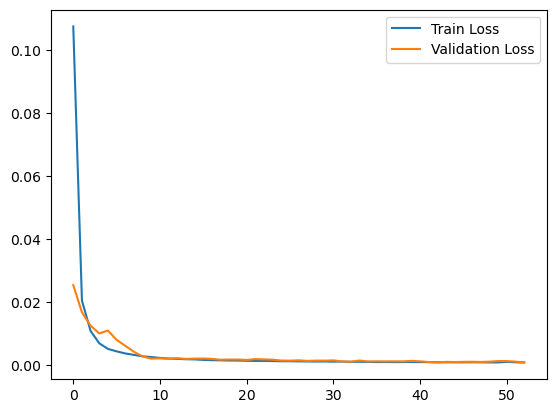

In [63]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Both the training and validation losses show a sharp decrease in the initial epochs, indicating that the model is learning quickly at the beginning.

The loss curves plateau after around 10-15 epochs, suggesting that the model has converged to a minimum.

The training loss and validation loss are very close to each other, with no significant divergence. This indicates that the model is not overfitting and generalizes well on the validation data.

The small gap between training and validation loss also suggests that the model is well-regularized.

The use of early stopping (as indicated by the EarlyStopping callback in the code) appears to have been effective. The training seems to have stopped at an optimal point where both training and validation losses are minimized without further improvement.

The losses are relatively low, which is a positive indication that the model performs well on the given task.

Since the model shows stable performance with low loss values, it is likely to provide reliable predictions.

## 4. Make forecast

In [65]:
# Make predictions
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 5ms/step


In [66]:
# Inverse transform the predictions and actual values
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

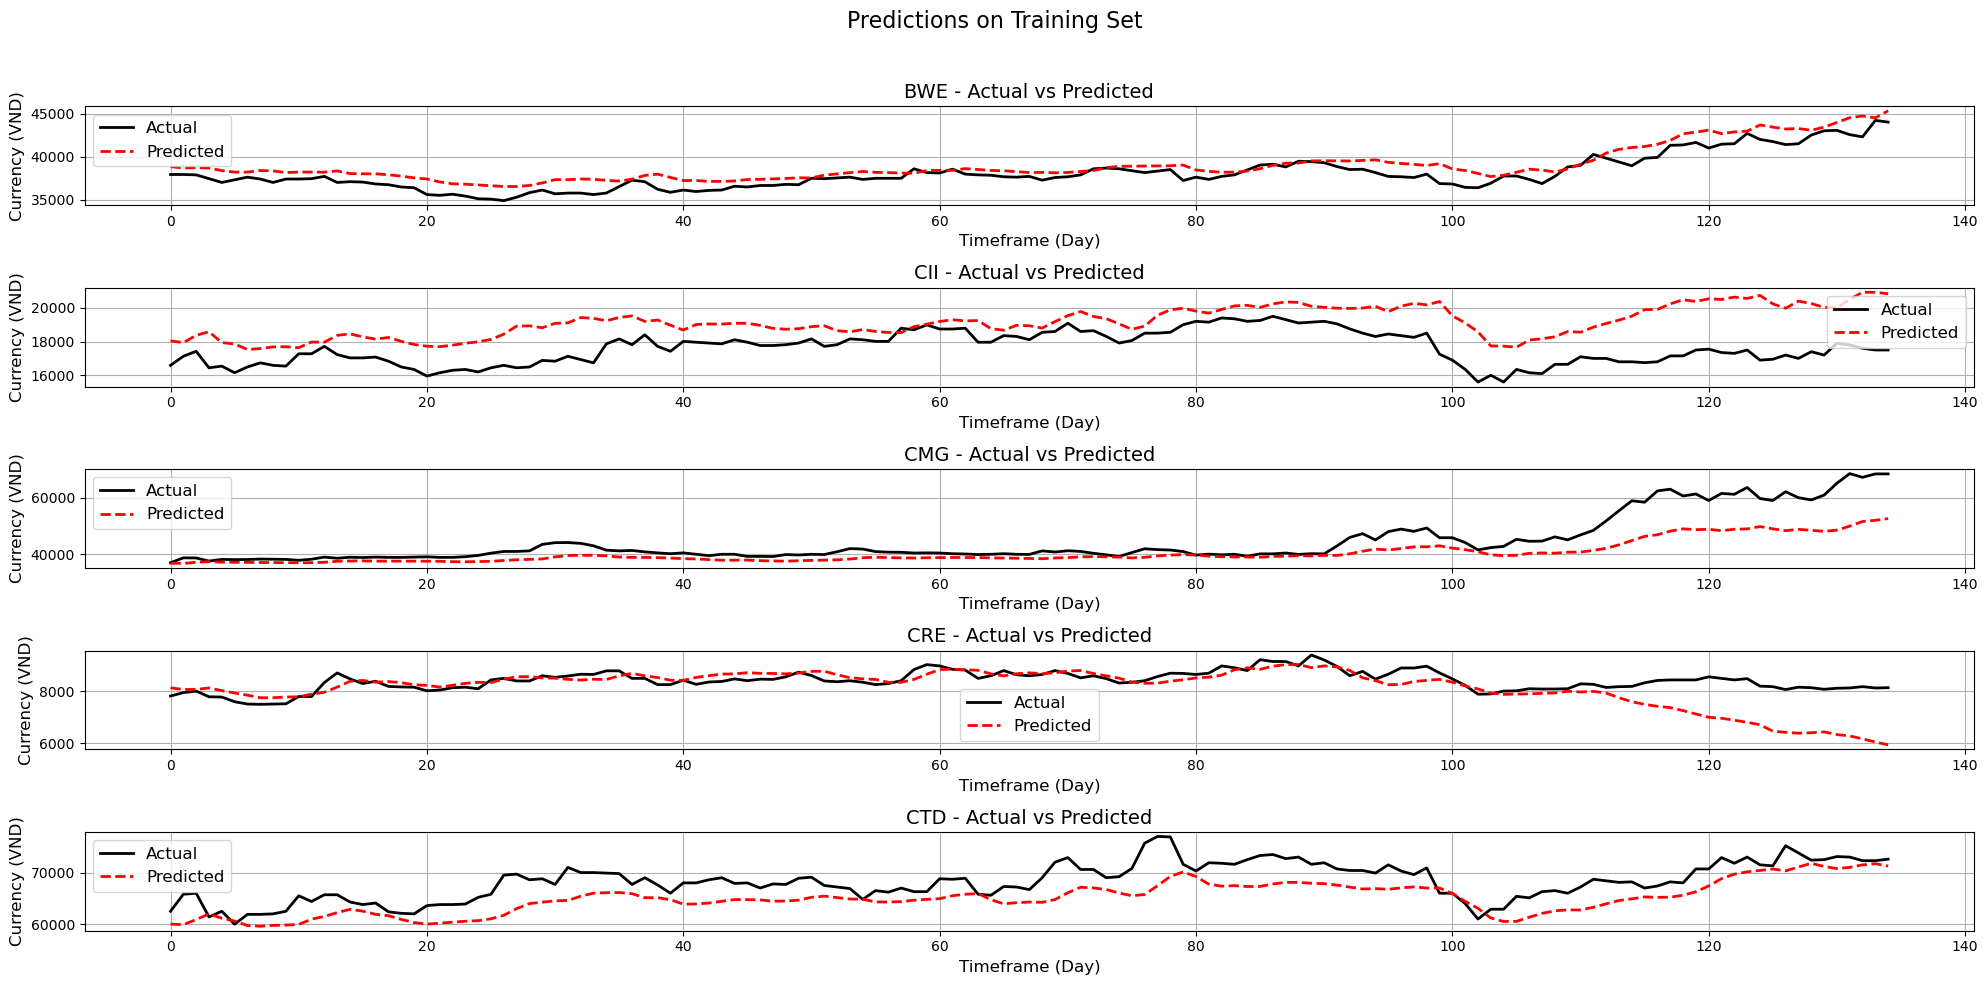

In [67]:
plt.figure(figsize=(20, 10))

for i, col in enumerate(cols):
    plt.subplot(len(cols), 1, i + 1)
    plt.plot(y_test_inverse[:, i], label='Actual', color='black', linestyle='-', linewidth=2)
    plt.plot(y_pred_inverse[:, i], label='Predicted', color='red', linestyle='--', linewidth=2)
    plt.title(f'{col} - Actual vs Predicted', fontsize=14)
    plt.xlabel('Timeframe (Day)', fontsize=12)
    plt.ylabel('Currency (VND)', fontsize=12)
    plt.grid(True)
    plt.legend(loc='best', fontsize=12)

plt.suptitle('Predictions on Training Set', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The model is strong in capturing the overall trends and directional movements of the time series data.

This is crucial for applications where understanding the general direction is more important than exact values.

The close alignment of predicted and actual values across different series indicates good generalization capabilities of the Bidirectional-GRU model.

## 5. Model evaluation

In [68]:
def calculate_series_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    percentage_diff = np.abs((y_true - y_pred) / y_true) * 100
    
    accuracy = 100 - np.mean(percentage_diff)
    
    return accuracy

In [69]:
# Calculate metrics for each series
metrics = {'accuracy': []}
for i, col in enumerate(cols):
    acc = calculate_series_accuracy(y_test_inverse[:, i], y_pred_inverse[:, i])
    metrics['accuracy'].append(acc)

In [70]:
print("Metrics for each series:")
for i, col in enumerate(cols):
    print(f"{col}:")
    print(f"  Accuracy score: {metrics['accuracy'][i]}")
    print('-'*30)

Metrics for each series:
BWE:
  Accuracy score: 97.4874328034284
------------------------------
CII:
  Accuracy score: 91.07986393149599
------------------------------
CMG:
  Accuracy score: 91.918457097173
------------------------------
CRE:
  Accuracy score: 95.19573868156486
------------------------------
CTD:
  Accuracy score: 95.2492426754074
------------------------------


## 6. Hyperparameters tuning and Forecasting using best_params model

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'batch_size': 32, 'epochs': 100, 'model__activation': 'tanh', 'model__optimizer': 'adam', 'model__units': 150}
Best score: 0.8347689250306942
Epoch 1/100
14/14 [==============================] - 3s 58ms/step - loss: 0.0473 - val_loss: 0.0252
Epoch 2/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0097 - val_loss: 0.0099
Epoch 3/100
14/14 [==============================] - 0s 23ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 4/100
14/14 [==============================] - 0s 27ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 5/100
14/14 [==============================] - 0s 28ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/100
14/14 [==============================] - 0s 28ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 7/100
14/14 [==============================] - 0s 29ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 8/100
14/14 [==============================] - 0s 28ms/step - loss: 0.002

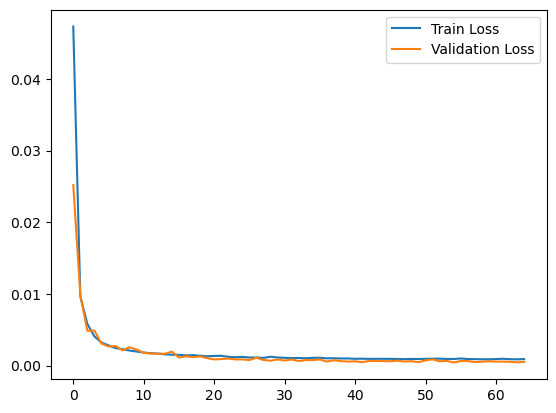

In [73]:
def create_model(activation='relu', units=100, optimizer='adam'):
    model = Sequential([
        Bidirectional(GRU(units, activation=activation), input_shape=(SEQ_LENGTH, len(cols))),
        Dense(len(cols))
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Wrap the Keras model
model = KerasRegressor(model=create_model, verbose=0)

# Define the parameter grid
param_grid = {
    'model__units': [100, 150],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam'],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

# Perform Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best score: {grid_result.best_score_}")

# Train the model with the best parameters
best_params = grid_result.best_params_
best_model = create_model(units=best_params['model__units'], activation=best_params['model__activation'], optimizer=best_params['model__optimizer'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [74]:
# Make predictions
y_pred = best_model.predict(X_test)

# Inverse transform the predictions and actual values
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

5/5 [==============================] - 0s 5ms/step


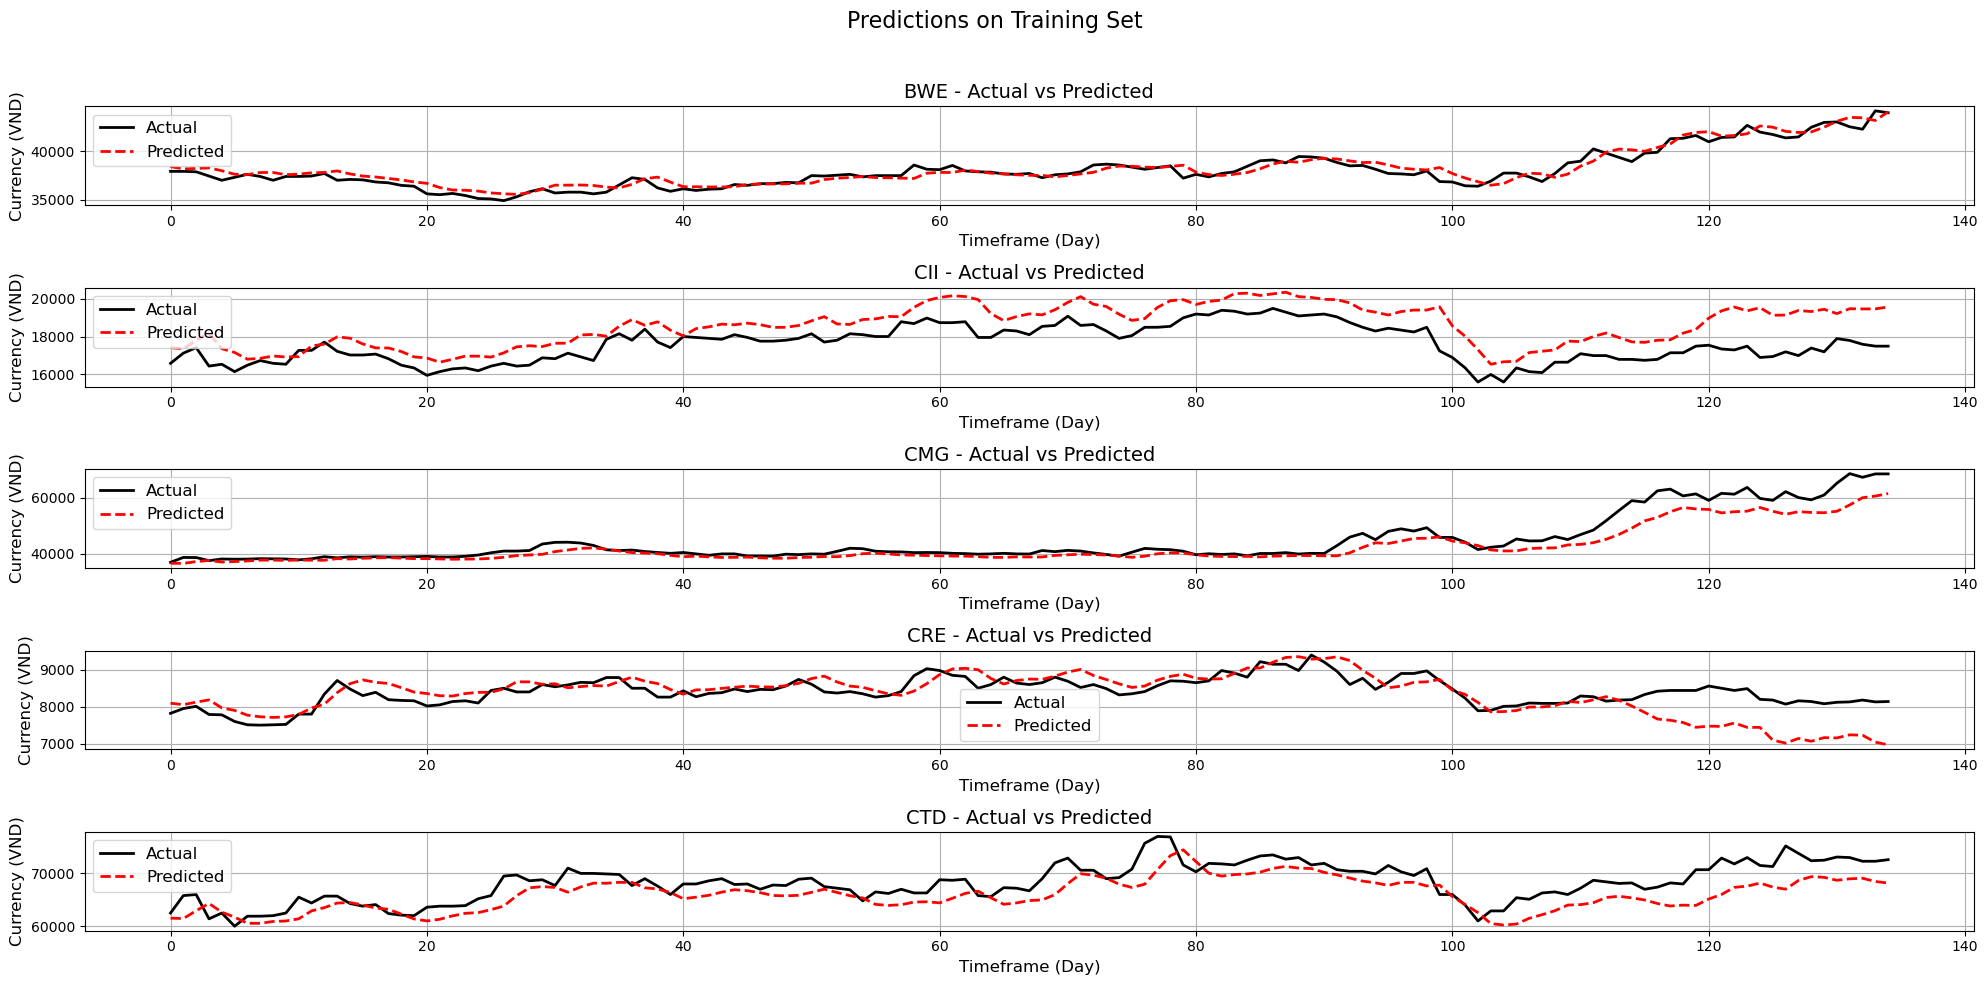

In [75]:
plt.figure(figsize=(20, 10))

for i, col in enumerate(cols):
    plt.subplot(len(cols), 1, i + 1)
    plt.plot(y_test_inverse[:, i], label='Actual', color='black', linestyle='-', linewidth=2)
    plt.plot(y_pred_inverse[:, i], label='Predicted', color='red', linestyle='--', linewidth=2)
    plt.title(f'{col} - Actual vs Predicted', fontsize=14)
    plt.xlabel('Timeframe (Day)', fontsize=12)
    plt.ylabel('Currency (VND)', fontsize=12)
    plt.grid(True)
    plt.legend(loc='best', fontsize=12)

plt.suptitle('Predictions on Training Set', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [76]:
# Calculate metrics for each series
metrics = {'accuracy': []}
for i, col in enumerate(cols):
    acc = calculate_series_accuracy(y_test_inverse[:, i], y_pred_inverse[:, i])
    metrics['accuracy'].append(acc)

In [77]:
print("Metrics for each series:")
for i, col in enumerate(cols):
    print(f"{col}:")
    print(f"  Accuracy score: {metrics['accuracy'][i]}")
    print('-'*30)

Metrics for each series:
BWE:
  Accuracy score: 98.76197962643286
------------------------------
CII:
  Accuracy score: 94.43245444744989
------------------------------
CMG:
  Accuracy score: 95.4337329643173
------------------------------
CRE:
  Accuracy score: 96.4002145183086
------------------------------
CTD:
  Accuracy score: 96.36256741430344
------------------------------


1/1 [==============================] - 0s 20ms/step


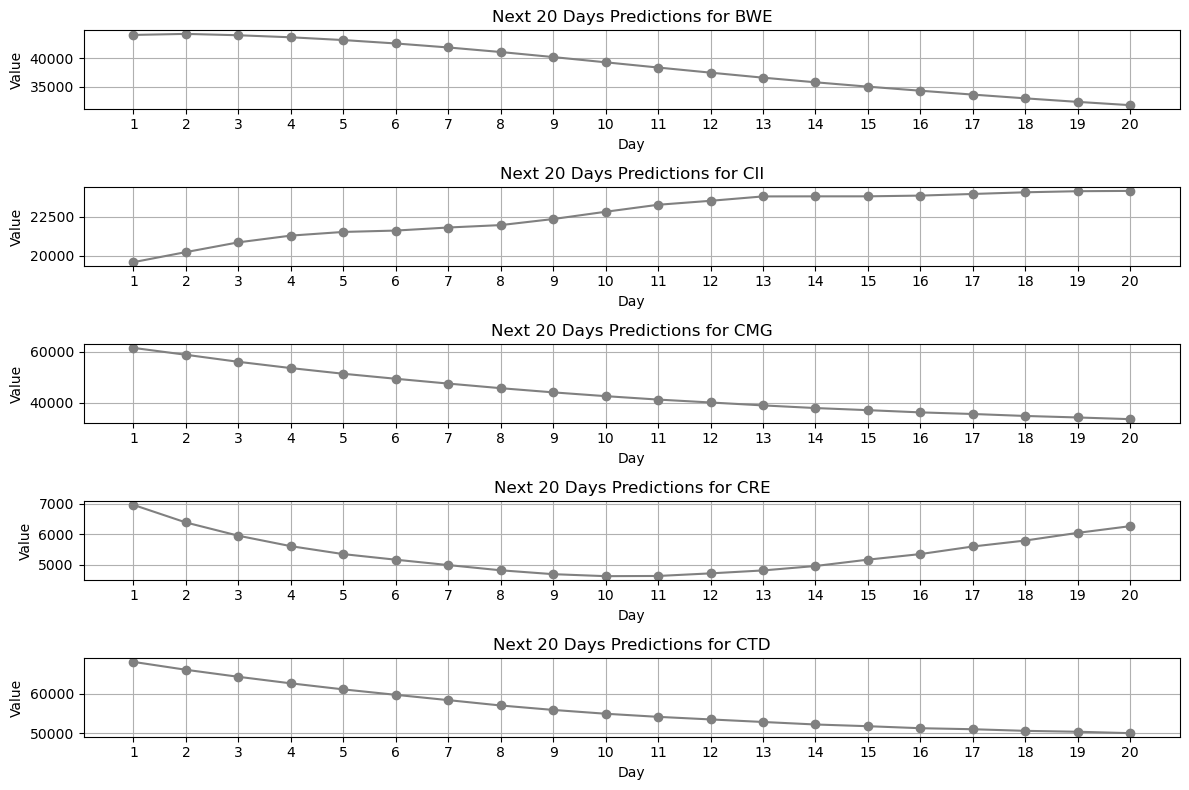

In [79]:
# Predict the next 20 days
last_sequence = X_test[-1]  # Start with the last sequence from the test set
predictions = []

for _ in range(20):
    # Predict the next value
    next_pred = best_model.predict(np.expand_dims(last_sequence, axis=0))[0]
    
    # Append the prediction to the list of predictions
    predictions.append(next_pred)
    
    # Update the last_sequence with the new prediction
    last_sequence = np.append(last_sequence[1:], [next_pred], axis=0)

# Inverse transform the predictions
predictions_inverse = scaler.inverse_transform(predictions)

# Plot the predictions for the next 20 days
plt.figure(figsize=(12, 8))

for i, col in enumerate(cols):
    plt.subplot(len(cols), 1, i + 1)
    plt.plot(range(1, 21), predictions_inverse[:, i], marker='o', linestyle='-', label='Predicted', color='grey')
    plt.title(f'Next 20 Days Predictions for {col}')
    plt.xlabel('Day')
    plt.ylabel('Value')
    plt.xticks(range(1, 21))
    plt.grid(True)

plt.tight_layout()
plt.show()

In [80]:
predictions_df = pd.DataFrame(predictions_inverse, columns=cols)
predictions_df

,BWE,CII,CMG,CRE,CTD
0,44101.670070,19573.764886,61434.244765,6967.061130,68173.391479
1,44282.590940,20226.142194,58736.271473,6388.409781,66164.932689
2,44042.704472,20857.727651,55978.913609,5953.243569,64373.283184
3,43683.806559,21294.335414,53522.739016,5609.811838,62705.837309
4,43195.541492,21531.554731,51297.944778,5348.517693,61166.482714
5,42595.032103,21620.429502,49332.213070,5165.029396,59778.257453
6,41889.973060,21818.844395,47448.113756,4988.345885,58430.556777
7,41087.407206,21974.895506,45643.470092,4816.426254,57062.897408
8,40198.860282,22367.063402,44003.724524,4689.293250,55931.260818
9,39273.333136,22838.764930,42519.965915,4623.728265,54959.680170


In [ ]:
# predictions_df.to_csv('predictions.csv', index=False)